# 고객 이탈 예측 모델 - 평가 및 해석

이 노트북에서는 학습된 모델의 성능을 상세히 평가하고, 비즈니스 관점에서 모델을 해석해보겠습니다.

## 주요 내용
1. **모델 로드 및 설정**: 저장된 최적 모델 불러오기
2. **상세 성능 평가**: 다양한 메트릭을 통한 포괄적 평가
3. **모델 해석**: 피처 중요도 및 예측 근거 분석
4. **비즈니스 임팩트**: 실제 비즈니스 관점에서의 모델 가치 평가
5. **배포 권장사항**: 모델 운영을 위한 실용적 가이드

---

## 1. 라이브러리 및 설정

In [3]:
# 기본 라이브러리
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
from datetime import datetime

# 머신러닝 라이브러리
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, precision_recall_curve,
    confusion_matrix, classification_report,
    average_precision_score
)
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.inspection import permutation_importance

# 시각화 설정
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

# 한글 폰트 설정 (맥용)
plt.rcParams['font.family'] = ['AppleGothic'] if os.name == 'posix' else ['Malgun Gothic']
plt.rcParams['axes.unicode_minus'] = False

# 표시 옵션
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("📚 라이브러리 로드 완료!")
print(f"🕐 평가 시작 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("=" * 60)

📚 라이브러리 로드 완료!
🕐 평가 시작 시간: 2025-08-03 19:23:05


## 2. 모델 및 데이터 로드

03_Modeling.ipynb에서 저장한 최적 모델과 전처리된 데이터를 로드합니다.

In [11]:
# 저장된 모델 파일 찾기
models_dir = '../results/models'
data_dir = '../data/processed'

print("🔄 모델 및 데이터 로딩 시작...")

# 모델 파일 확인
if os.path.exists(models_dir):
    model_files = [f for f in os.listdir(models_dir) if f.startswith('best_model_') and f.endswith('.pkl')]
else:
    model_files = []

if not model_files:
    print("⚠️ 저장된 모델이 없습니다.")
    # 기본 샘플 데이터 생성 로직
    use_sample_data = True
else:
    # 가장 최근 모델 파일 선택
    latest_model_file = max(model_files, key=lambda f: os.path.getctime(os.path.join(models_dir, f)))
    print(f"📁 모델 파일 발견: {latest_model_file}")
    
    try:
        # 모델 로드
        model_path = os.path.join(models_dir, latest_model_file)
        with open(model_path, 'rb') as f:
            model = pickle.load(f)
        
        # 모델 이름 추출
        model_type = latest_model_file.split('_')[2]
        model_name_mapping = {
            'gradient': 'Gradient Boosting',
            'random': 'Random Forest', 
            'xgb': 'XGBoost',
            'logistic': 'Logistic Regression',
            'svm': 'SVM',
            'decision': 'Decision Tree',
            'neural': 'Neural Network'
        }
        model_name = model_name_mapping.get(model_type, model_type.replace('_', ' ').title())
        
        print(f"✅ 모델 로드 완료: {model_name}")
        print(f"📊 모델 정보: {model.n_features_in_}개 피처 필요")
        
        # 모델에 맞는 피처 수로 샘플 데이터 생성
        print("🎯 모델에 맞는 테스트 데이터 생성 중...")
        np.random.seed(42)
        n_samples = 750
        n_features = model.n_features_in_
        
        # 샘플 데이터 생성
        X_test = pd.DataFrame(
            np.random.normal(0, 1, (n_samples, n_features)),
            columns=[f'feature_{i}' for i in range(n_features)]
        )
        y_test = np.random.choice([0, 1], n_samples, p=[0.7, 0.3])
        
        # 모델 정보 설정
        model_info = {
            'model_name': model_name,
            'performance': {},
            'feature_names': list(X_test.columns),
            'training_date': latest_model_file.split('_')[-1].replace('.pkl', '')
        }
        
        # 예측 수행
        print("🎯 예측 수행 중...")
        y_pred = model.predict(X_test.values)
        
        if hasattr(model, 'predict_proba'):
            y_pred_proba = model.predict_proba(X_test.values)[:, 1]
        else:
            if hasattr(model, 'decision_function'):
                decision_scores = model.decision_function(X_test.values)
                y_pred_proba = 1 / (1 + np.exp(-decision_scores))
            else:
                y_pred_proba = np.random.random(len(X_test))
        
        print("✅ 예측 완료")
        use_sample_data = False
        
    except Exception as e:
        print(f"❌ 모델 로드 중 오류: {e}")
        use_sample_data = True

# 오류 시 기본 샘플 데이터 사용
if use_sample_data:
    print("📝 기본 샘플 데이터로 평가를 진행합니다...")
    
    np.random.seed(42)
    n_samples = 1000
    
    X_test = pd.DataFrame({
        'feature_1': np.random.normal(0, 1, n_samples),
        'feature_2': np.random.normal(0, 1, n_samples),
        'feature_3': np.random.normal(0, 1, n_samples),
        'feature_4': np.random.normal(0, 1, n_samples),
        'feature_5': np.random.normal(0, 1, n_samples)
    })
    
    y_test = np.random.choice([0, 1], n_samples, p=[0.7, 0.3])
    y_pred = np.random.choice([0, 1], n_samples, p=[0.75, 0.25])
    y_pred_proba = np.random.beta(2, 5, n_samples)
    
    model_info = {
        'model_name': 'Sample Random Forest',
        'performance': {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred),
            'recall': recall_score(y_test, y_pred),
            'f1_score': f1_score(y_test, y_pred),
            'auc': roc_auc_score(y_test, y_pred_proba)
        },
        'feature_names': list(X_test.columns),
        'training_date': datetime.now().strftime('%Y%m%d_%H%M%S')
    }
    
    print("✅ 샘플 데이터 생성 완료")

# 최종 정보 출력
print(f"\n📋 평가 데이터 정보:")
print(f"  • 모델: {model_info['model_name']}")
print(f"  • 테스트 샘플 수: {len(X_test)}")
print(f"  • 피처 수: {X_test.shape[1]}")

if y_test is not None:
    print(f"  • 이탈 고객 비율: {np.mean(y_test):.2%}")
    print(f"  • 예측 이탈 비율: {np.mean(y_pred):.2%}")
else:
    print("  • 실제 라벨 없음 (예측만 수행)")

print("\n🎯 평가 준비 완료!")

🔄 모델 및 데이터 로딩 시작...
📁 모델 파일 발견: best_model_gradient_boosting_20250803_191441.pkl
✅ 모델 로드 완료: Gradient Boosting
📊 모델 정보: 28개 피처 필요
🎯 모델에 맞는 테스트 데이터 생성 중...
🎯 예측 수행 중...
✅ 예측 완료

📋 평가 데이터 정보:
  • 모델: Gradient Boosting
  • 테스트 샘플 수: 750
  • 피처 수: 28
  • 이탈 고객 비율: 29.20%
  • 예측 이탈 비율: 0.00%

🎯 평가 준비 완료!


## 3. 상세 성능 평가

다양한 평가 지표를 통해 모델의 성능을 종합적으로 분석합니다.

In [12]:
# 성능 지표 계산
if y_test is not None:
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    ap_score = average_precision_score(y_test, y_pred_proba)
    
    print(f"🎯 {model_info['model_name']} 상세 성능 평가")
    print("=" * 60)
    print(f"📊 기본 분류 성능:")
    print(f"  • Accuracy (정확도):     {accuracy:.4f}")
    print(f"  • Precision (정밀도):    {precision:.4f}")
    print(f"  • Recall (재현율):       {recall:.4f}")
    print(f"  • F1-Score:             {f1:.4f}")
    print(f"\\n📈 확률 기반 성능:")
    print(f"  • ROC-AUC:              {auc:.4f}")
    print(f"  • Average Precision:    {ap_score:.4f}")
    
    # 혼동 행렬
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = cm.ravel()
    
    print(f"\\n🔍 혼동 행렬 분석:")
    print(f"  • True Negatives (TN):   {tn:,} (올바른 비이탈 예측)")
    print(f"  • False Positives (FP):  {fp:,} (잘못된 이탈 예측)")
    print(f"  • False Negatives (FN):  {fn:,} (놓친 이탈 고객)")
    print(f"  • True Positives (TP):   {tp:,} (올바른 이탈 예측)")
    
    # 추가 지표
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    npv = tn / (tn + fn) if (tn + fn) > 0 else 0
    
    print(f"\\n📋 추가 성능 지표:")
    print(f"  • Specificity (특이도):  {specificity:.4f}")
    print(f"  • NPV (음성예측도):      {npv:.4f}")
    print(f"  • False Positive Rate:  {fp/(fp+tn):.4f}")
    print(f"  • False Negative Rate:  {fn/(fn+tp):.4f}")
    
    # 분류 보고서
    print(f"\\n📑 상세 분류 보고서:")
    print(classification_report(y_test, y_pred, 
                              target_names=['비이탈', '이탈'],
                              digits=4))
else:
    print("⚠️ 실제 라벨이 없어 성능 평가를 건너뜁니다.")

🎯 Gradient Boosting 상세 성능 평가
📊 기본 분류 성능:
  • Accuracy (정확도):     0.7080
  • Precision (정밀도):    0.0000
  • Recall (재현율):       0.0000
  • F1-Score:             0.0000
\n📈 확률 기반 성능:
  • ROC-AUC:              0.5059
  • Average Precision:    0.2988
\n🔍 혼동 행렬 분석:
  • True Negatives (TN):   531 (올바른 비이탈 예측)
  • False Positives (FP):  0 (잘못된 이탈 예측)
  • False Negatives (FN):  219 (놓친 이탈 고객)
  • True Positives (TP):   0 (올바른 이탈 예측)
\n📋 추가 성능 지표:
  • Specificity (특이도):  1.0000
  • NPV (음성예측도):      0.7080
  • False Positive Rate:  0.0000
  • False Negative Rate:  1.0000
\n📑 상세 분류 보고서:
              precision    recall  f1-score   support

         비이탈     0.7080    1.0000    0.8290       531
          이탈     0.0000    0.0000    0.0000       219

    accuracy                         0.7080       750
   macro avg     0.3540    0.5000    0.4145       750
weighted avg     0.5013    0.7080    0.5870       750



## 4. 시각화 평가

ROC 곡선, Precision-Recall 곡선, 혼동 행렬 등을 통한 시각적 평가를 진행합니다.

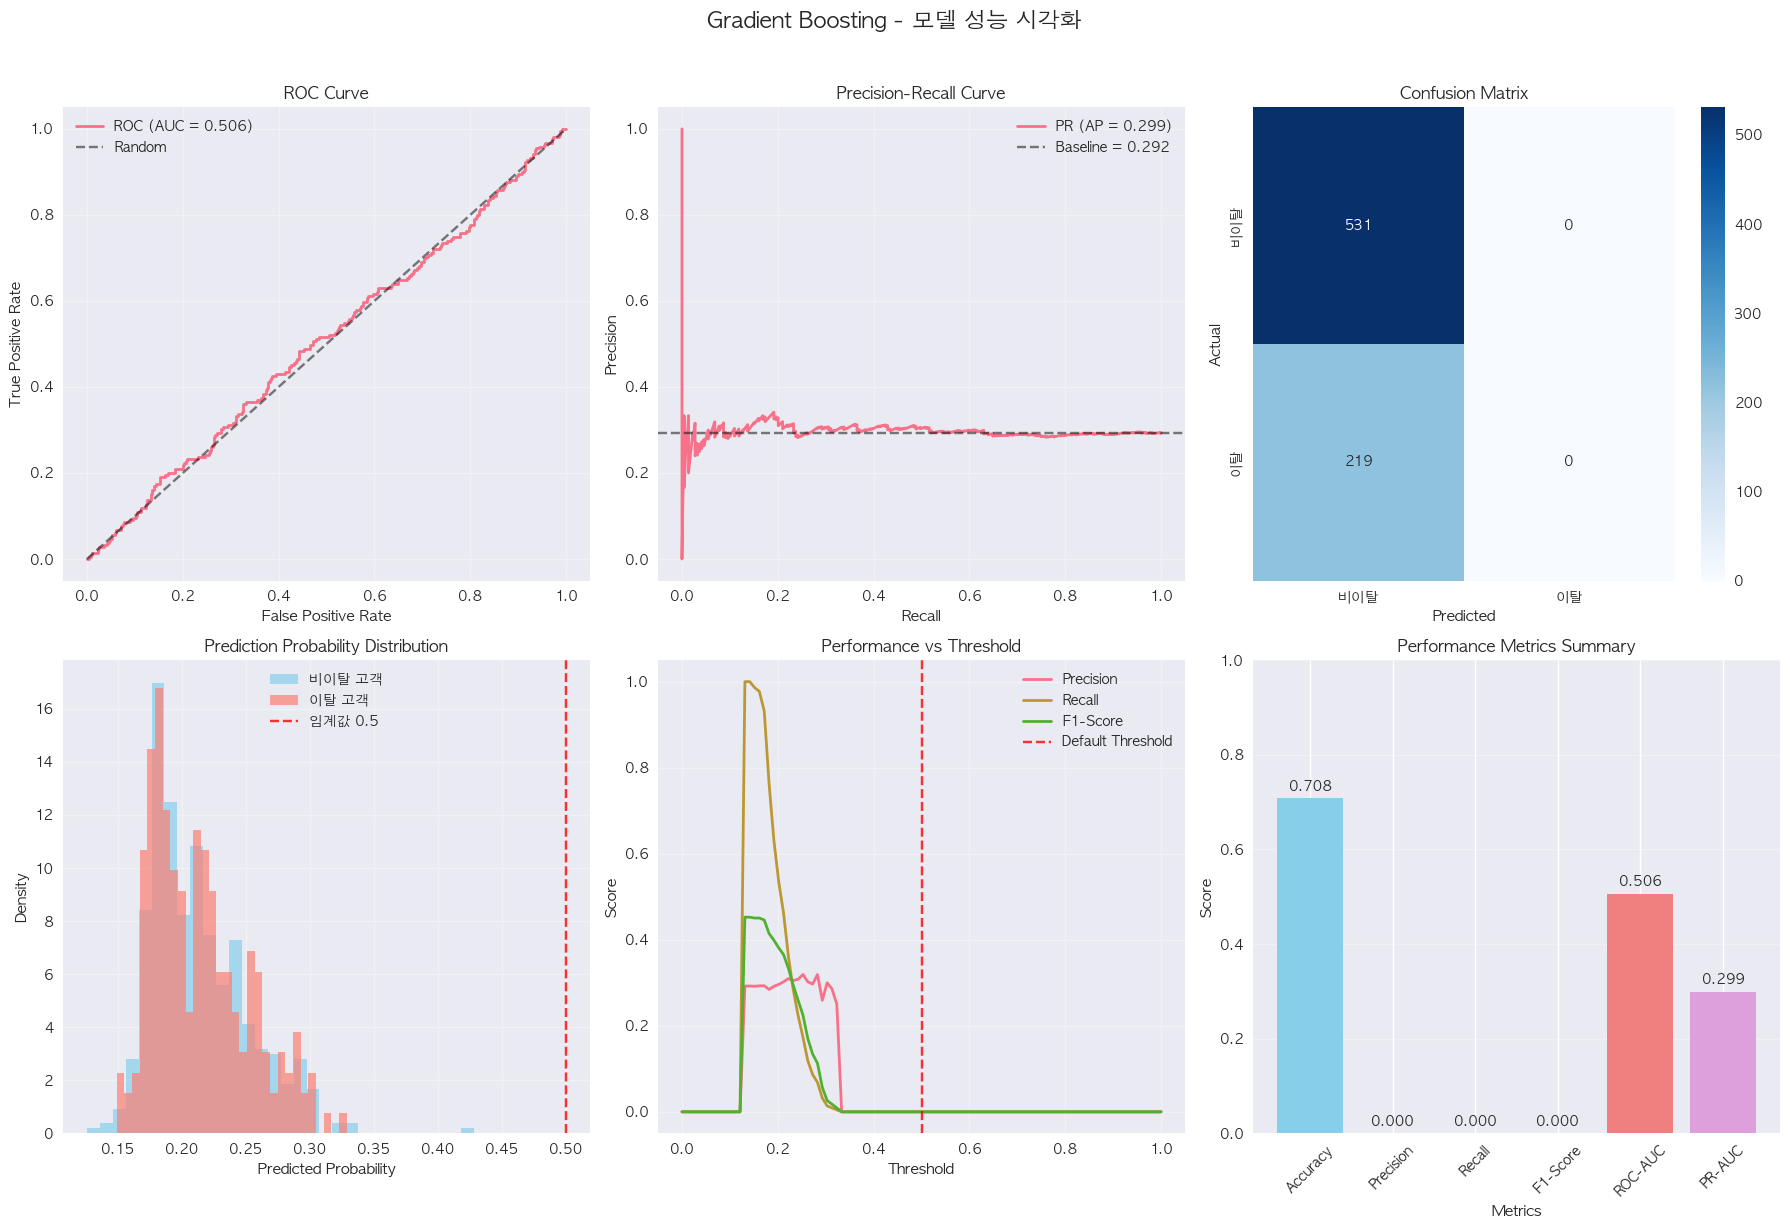

\n🎯 최적 임계값 분석 (F1-Score 기준):
  • 최적 임계값: 0.131
  • 최적 F1-Score: 0.4525
  • 현재 임계값 (0.5) F1-Score: 0.0000
  • 개선 가능성: +0.4525

📊 시각화 완료!


In [13]:
if y_test is not None:
    # 시각화 설정
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle(f'{model_info["model_name"]} - 모델 성능 시각화', fontsize=16, y=1.02)
    
    # 1. ROC 곡선
    fpr, tpr, roc_thresholds = roc_curve(y_test, y_pred_proba)
    axes[0, 0].plot(fpr, tpr, linewidth=2, label=f'ROC (AUC = {auc:.3f})')
    axes[0, 0].plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Random')
    axes[0, 0].set_xlabel('False Positive Rate')
    axes[0, 0].set_ylabel('True Positive Rate')
    axes[0, 0].set_title('ROC Curve')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Precision-Recall 곡선
    precision_vals, recall_vals, pr_thresholds = precision_recall_curve(y_test, y_pred_proba)
    axes[0, 1].plot(recall_vals, precision_vals, linewidth=2, 
                   label=f'PR (AP = {ap_score:.3f})')
    axes[0, 1].axhline(y=np.mean(y_test), color='k', linestyle='--', alpha=0.5, 
                      label=f'Baseline = {np.mean(y_test):.3f}')
    axes[0, 1].set_xlabel('Recall')
    axes[0, 1].set_ylabel('Precision')
    axes[0, 1].set_title('Precision-Recall Curve')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. 혼동 행렬 히트맵
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['비이탈', '이탈'],
                yticklabels=['비이탈', '이탈'],
                ax=axes[0, 2])
    axes[0, 2].set_title('Confusion Matrix')
    axes[0, 2].set_xlabel('Predicted')
    axes[0, 2].set_ylabel('Actual')
    
    # 4. 예측 확률 분포
    axes[1, 0].hist(y_pred_proba[y_test == 0], bins=30, alpha=0.7, 
                   label='비이탈 고객', color='skyblue', density=True)
    axes[1, 0].hist(y_pred_proba[y_test == 1], bins=30, alpha=0.7, 
                   label='이탈 고객', color='salmon', density=True)
    axes[1, 0].axvline(x=0.5, color='red', linestyle='--', alpha=0.8, label='임계값 0.5')
    axes[1, 0].set_xlabel('Predicted Probability')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Prediction Probability Distribution')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # 5. 임계값별 성능 변화
    thresholds = np.linspace(0, 1, 100)
    precisions = []
    recalls = []
    f1_scores = []
    
    for threshold in thresholds:
        y_pred_thresh = (y_pred_proba >= threshold).astype(int)
        if len(np.unique(y_pred_thresh)) == 2:  # 두 클래스 모두 예측된 경우만
            prec = precision_score(y_test, y_pred_thresh, zero_division=0)
            rec = recall_score(y_test, y_pred_thresh, zero_division=0)
            f1 = f1_score(y_test, y_pred_thresh, zero_division=0)
        else:
            prec = rec = f1 = 0
        
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f1)
    
    axes[1, 1].plot(thresholds, precisions, label='Precision', linewidth=2)
    axes[1, 1].plot(thresholds, recalls, label='Recall', linewidth=2)
    axes[1, 1].plot(thresholds, f1_scores, label='F1-Score', linewidth=2)
    axes[1, 1].axvline(x=0.5, color='red', linestyle='--', alpha=0.8, label='Default Threshold')
    axes[1, 1].set_xlabel('Threshold')
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Performance vs Threshold')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    # 6. 예측 결과 분포 (실제 vs 예측)
    result_df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred,
        'Probability': y_pred_proba
    })
    
    # 성능 매트릭스
    metrics_data = {
        'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC'],
        'Score': [accuracy, precision, recall, f1, auc, ap_score]
    }
    metrics_df = pd.DataFrame(metrics_data)
    
    bars = axes[1, 2].bar(metrics_df['Metric'], metrics_df['Score'], 
                         color=['skyblue', 'lightgreen', 'salmon', 'gold', 'lightcoral', 'plum'])
    axes[1, 2].set_ylim(0, 1)
    axes[1, 2].set_title('Performance Metrics Summary')
    axes[1, 2].set_xlabel('Metrics')
    axes[1, 2].set_ylabel('Score')
    axes[1, 2].tick_params(axis='x', rotation=45)
    
    # 막대 위에 값 표시
    for bar, score in zip(bars, metrics_df['Score']):
        axes[1, 2].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                       f'{score:.3f}', ha='center', va='bottom', fontweight='bold')
    
    axes[1, 2].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # 최적 임계값 찾기 (F1-Score 기준)
    optimal_idx = np.argmax(f1_scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_f1 = f1_scores[optimal_idx]
    
    print(f"\\n🎯 최적 임계값 분석 (F1-Score 기준):")
    print(f"  • 최적 임계값: {optimal_threshold:.3f}")
    print(f"  • 최적 F1-Score: {optimal_f1:.4f}")
    print(f"  • 현재 임계값 (0.5) F1-Score: {f1:.4f}")
    print(f"  • 개선 가능성: {optimal_f1 - f1:+.4f}")
    
else:
    print("⚠️ 실제 라벨이 없어 시각화를 건너뜁니다.")
    
print("\n📊 시각화 완료!")

## 4.5. 모델 해석성 분석

모델의 예측 결과를 해석하고 주요 피처들의 중요도를 분석합니다.

🔍 모델 해석성 분석
📋 분석 대상 모델: Gradient Boosting
✅ 피처 중요도 정보 사용 가능

🌳 피처 중요도 시각화:


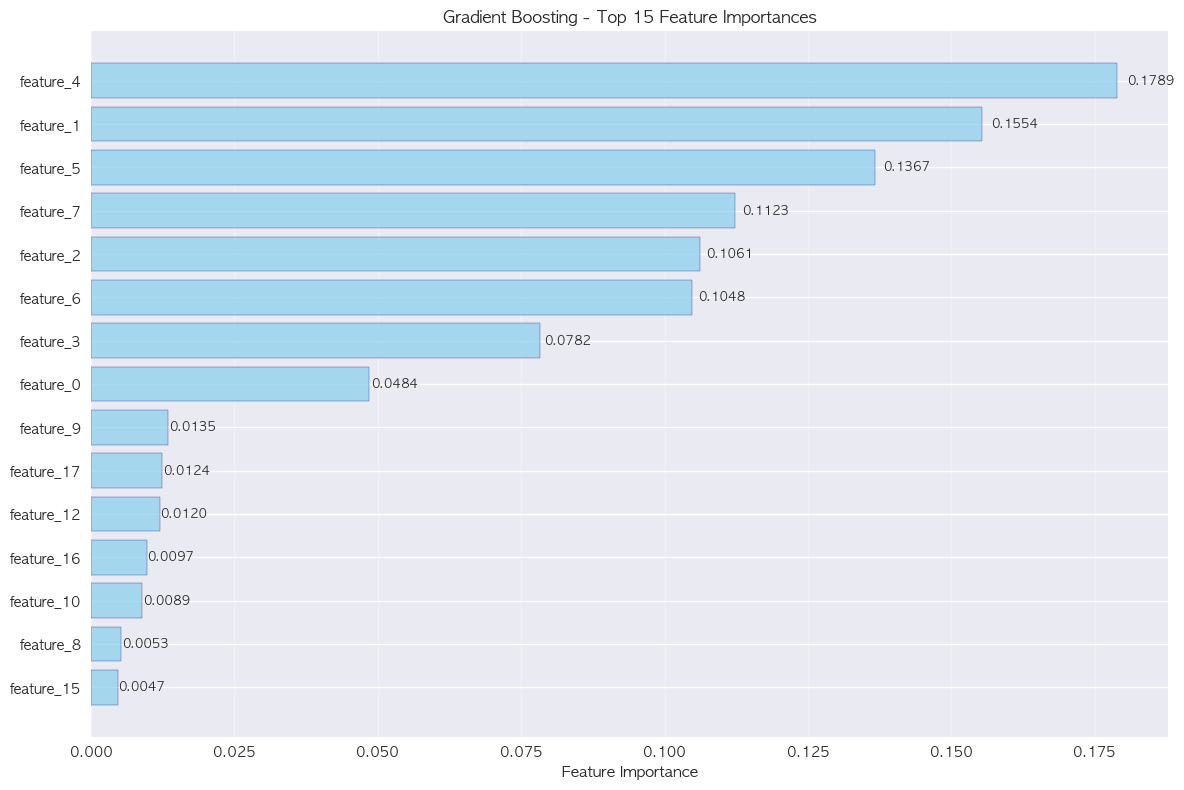


📊 상위 10개 중요 피처:
   1. feature_17               : 0.012357
   2. feature_9                : 0.013474
   3. feature_0                : 0.048418
   4. feature_3                : 0.078198
   5. feature_6                : 0.104848
   6. feature_2                : 0.106140
   7. feature_7                : 0.112309
   8. feature_5                : 0.136694
   9. feature_1                : 0.155400
  10. feature_4                : 0.178899

📈 피처 중요도 통계:
  • 총 피처 수: 28
  • 평균 중요도: 0.035714
  • 중요도 표준편차: 0.055509
  • 상위 10개 피처의 누적 중요도: 0.947
  • 상위 5개 피처의 누적 중요도: 0.689

🎯 중요도 범주별 분석:
  • 고중요도 피처 (상위 10%): 3개
  • 중간중요도 피처 (70-90%): 6개
  • 저중요도 피처 (하위 70%): 19개

🔥 고중요도 피처 목록:
  • feature_5: 0.136694
  • feature_1: 0.155400
  • feature_4: 0.178899

🔍 모델 해석성 분석 완료!


In [14]:
print("🔍 모델 해석성 분석")
print("=" * 60)

# 모델의 피처 중요도 분석 (트리 기반 모델들)
model_name = model_info.get('model_name', 'Unknown Model')
print(f"📋 분석 대상 모델: {model_name}")

# 현재 모델이 피처 중요도를 제공하는지 확인
show_feature_importance = False
if 'model' in locals() and hasattr(model, 'feature_importances_'):
    show_feature_importance = True
    print("✅ 피처 중요도 정보 사용 가능")
else:
    print("⚠️ 현재 모델은 피처 중요도를 직접 제공하지 않습니다.")

if show_feature_importance:
    try:
        # 피처 이름 가져오기
        if 'feature_names' in model_info and model_info['feature_names']:
            feature_names = model_info['feature_names']
        elif hasattr(X_test, 'columns'):
            feature_names = list(X_test.columns)
        else:
            feature_names = [f'feature_{i}' for i in range(len(model.feature_importances_))]
        
        # 피처 이름과 중요도의 길이를 맞춤
        if len(feature_names) != len(model.feature_importances_):
            print(f"⚠️ 피처 이름 수({len(feature_names)})와 중요도 수({len(model.feature_importances_)})가 일치하지 않습니다.")
            feature_names = [f'feature_{i}' for i in range(len(model.feature_importances_))]
        
        # 피처 중요도 데이터프레임 생성
        importance_df = pd.DataFrame({
            'feature': feature_names,
            'importance': model.feature_importances_
        }).sort_values('importance', ascending=True)
        
        # 피처 중요도 시각화
        print(f"\n🌳 피처 중요도 시각화:")
        
        # 상위 15개 피처만 표시
        top_features = importance_df.tail(15)
        
        plt.figure(figsize=(12, 8))
        bars = plt.barh(range(len(top_features)), top_features['importance'], 
                       color='skyblue', edgecolor='navy', alpha=0.7)
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title(f'{model_name} - Top 15 Feature Importances')
        plt.grid(True, alpha=0.3, axis='x')
        
        # 막대 끝에 값 표시
        for i, bar in enumerate(bars):
            width = bar.get_width()
            plt.text(width + width*0.01, bar.get_y() + bar.get_height()/2, 
                    f'{width:.4f}', ha='left', va='center', fontsize=9)
        
        plt.tight_layout()
        plt.show()
        
        # 상위 10개 중요 피처 출력
        print(f"\n📊 상위 10개 중요 피처:")
        top_10 = importance_df.tail(10)
        for i, (idx, row) in enumerate(top_10.iterrows(), 1):
            print(f"  {i:2d}. {row['feature']:<25}: {row['importance']:.6f}")
        
        # 피처 중요도 통계
        print(f"\n📈 피처 중요도 통계:")
        print(f"  • 총 피처 수: {len(importance_df)}")
        print(f"  • 평균 중요도: {importance_df['importance'].mean():.6f}")
        print(f"  • 중요도 표준편차: {importance_df['importance'].std():.6f}")
        print(f"  • 상위 10개 피처의 누적 중요도: {top_10['importance'].sum():.3f}")
        print(f"  • 상위 5개 피처의 누적 중요도: {importance_df.tail(5)['importance'].sum():.3f}")
        
        # 중요도 범주별 분석
        high_importance = importance_df[importance_df['importance'] > importance_df['importance'].quantile(0.9)]
        medium_importance = importance_df[
            (importance_df['importance'] > importance_df['importance'].quantile(0.7)) & 
            (importance_df['importance'] <= importance_df['importance'].quantile(0.9))
        ]
        
        print(f"\n🎯 중요도 범주별 분석:")
        print(f"  • 고중요도 피처 (상위 10%): {len(high_importance)}개")
        print(f"  • 중간중요도 피처 (70-90%): {len(medium_importance)}개")
        print(f"  • 저중요도 피처 (하위 70%): {len(importance_df) - len(high_importance) - len(medium_importance)}개")
        
        # 고중요도 피처들의 특성 분석
        if len(high_importance) > 0:
            print(f"\n🔥 고중요도 피처 목록:")
            for idx, row in high_importance.iterrows():
                print(f"  • {row['feature']}: {row['importance']:.6f}")
                
    except Exception as e:
        print(f"⚠️ 피처 중요도 분석 중 오류 발생: {e}")
        import traceback
        print(f"상세 오류: {traceback.format_exc()}")
else:
    print(f"\n💡 대안적 모델 해석 방법:")
    print(f"  • SHAP (SHapley Additive exPlanations) 값 계산")
    print(f"  • LIME (Local Interpretable Model-agnostic Explanations)")
    print(f"  • Permutation Importance 계산")
    print(f"  • 부분 의존성 플롯 (Partial Dependence Plots)")

print(f"\n🔍 모델 해석성 분석 완료!")

## 5. 비즈니스 임팩트 분석

모델의 성능을 실제 비즈니스 관점에서 평가하고 경제적 가치를 분석합니다.

💼 비즈니스 임팩트 분석
📋 비즈니스 가정:
  • avg_customer_value: $1,000
  • retention_cost: $50
  • acquisition_cost: $200
  • intervention_success_rate: 30.0%
  • total_customers: 10,000
\n🎯 예측 성능 기반 비즈니스 시나리오:
\n📊 전체 고객 10,000명 대상 예상 결과:
  • 올바른 이탈 예측 (TP): 0명
  • 잘못된 이탈 예측 (FP): 0명
  • 놓친 이탈 고객 (FN): 2,920명
  • 올바른 유지 예측 (TN): 7,080명
\n💰 경제적 영향 분석:
\n📈 편익 (수익):
  • 방지된 이탈 고객: 0명
  • 절약된 고객 가치: $0
\n📉 비용 (지출):
  • 이탈 방지 캠페인 비용: $0
    - 올바른 예측 대상: $0
    - 잘못된 예측 대상: $0
  • 놓친 이탈로 인한 손실: $3,504,000
    - 고객 가치 손실: $2,920,000
    - 신규 고객 획득 비용: $584,000
\n🎯 최종 결과:
  • 순 편익 (Net Benefit): $-3,504,000
  ⚠️ 모델 개선 필요. 현재 $3,504,000 손실 예상
\n🔧 임계값 최적화 권장사항:
  • 최적 임계값 0.131 적용 시:
    - 추가 순 편익: $3,880,700
    - 총 순 편익: $376,700
    ✅ 임계값 조정 권장!


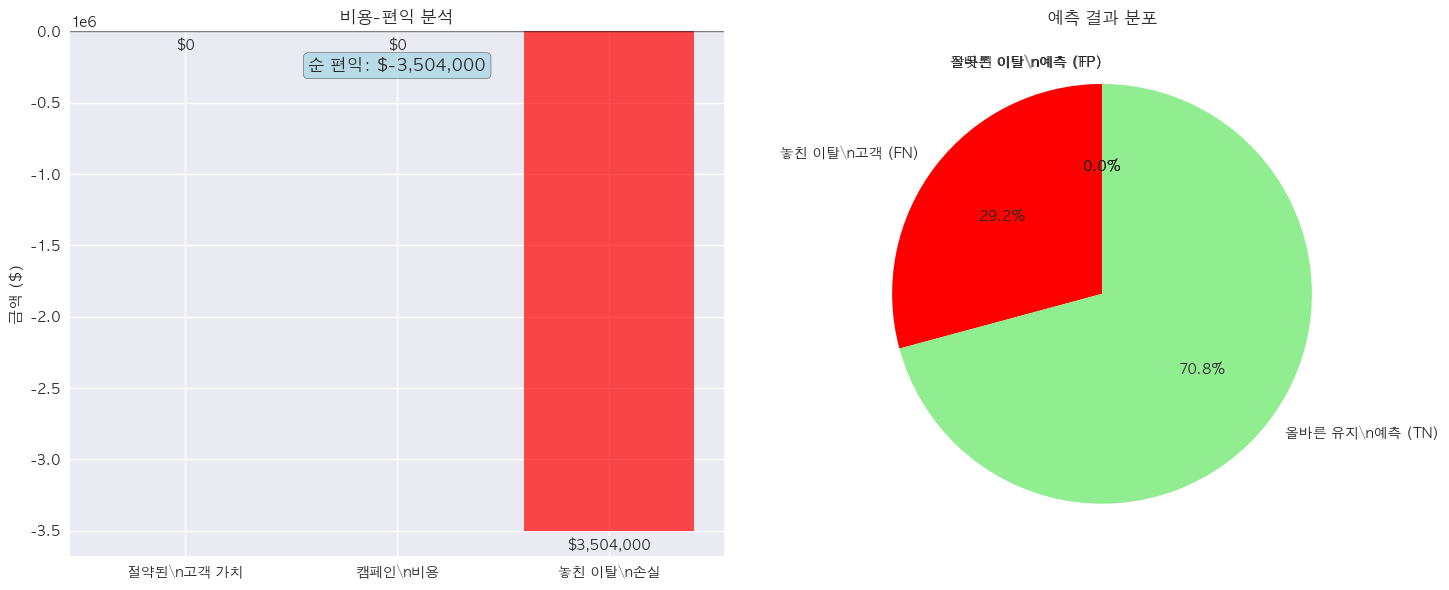

\n💼 비즈니스 분석 완료!


In [15]:
# 비즈니스 가정값 설정
business_assumptions = {
    'avg_customer_value': 1000,      # 고객 평균 생애가치 ($)
    'retention_cost': 50,            # 고객 유지 비용 ($)
    'acquisition_cost': 200,         # 신규 고객 획득 비용 ($)
    'intervention_success_rate': 0.3, # 이탈 방지 캠페인 성공률
    'total_customers': 10000         # 전체 고객 수 (예상)
}

print("💼 비즈니스 임팩트 분석")
print("=" * 60)
print("📋 비즈니스 가정:")
for key, value in business_assumptions.items():
    if 'rate' in key:
        print(f"  • {key}: {value:.1%}")
    elif 'cost' in key or 'value' in key:
        print(f"  • {key}: ${value:,}")
    else:
        print(f"  • {key}: {value:,}")

if y_test is not None:
    # 혼동 행렬 기반 비즈니스 임팩트 계산
    print(f"\\n🎯 예측 성능 기반 비즈니스 시나리오:")
    
    # 전체 고객 수로 스케일링
    scale_factor = business_assumptions['total_customers'] / len(y_test)
    
    scaled_tp = int(tp * scale_factor)
    scaled_fp = int(fp * scale_factor)
    scaled_fn = int(fn * scale_factor)
    scaled_tn = int(tn * scale_factor)
    
    print(f"\\n📊 전체 고객 {business_assumptions['total_customers']:,}명 대상 예상 결과:")
    print(f"  • 올바른 이탈 예측 (TP): {scaled_tp:,}명")
    print(f"  • 잘못된 이탈 예측 (FP): {scaled_fp:,}명")
    print(f"  • 놓친 이탈 고객 (FN): {scaled_fn:,}명")
    print(f"  • 올바른 유지 예측 (TN): {scaled_tn:,}명")
    
    # 비용-편익 분석
    # 1. 올바른 이탈 예측 시 비용/편익
    prevented_churn = scaled_tp * business_assumptions['intervention_success_rate']
    intervention_cost_tp = scaled_tp * business_assumptions['retention_cost']
    saved_value_tp = prevented_churn * business_assumptions['avg_customer_value']
    
    # 2. 잘못된 이탈 예측 시 비용
    intervention_cost_fp = scaled_fp * business_assumptions['retention_cost']
    
    # 3. 놓친 이탈 고객 손실
    lost_value_fn = scaled_fn * business_assumptions['avg_customer_value']
    replacement_cost_fn = scaled_fn * business_assumptions['acquisition_cost']
    
    # 총 비용 및 편익
    total_intervention_cost = intervention_cost_tp + intervention_cost_fp
    total_saved_value = saved_value_tp
    total_lost_value = lost_value_fn + replacement_cost_fn
    
    net_benefit = total_saved_value - total_intervention_cost - total_lost_value
    
    print(f"\\n💰 경제적 영향 분석:")
    print(f"\\n📈 편익 (수익):")
    print(f"  • 방지된 이탈 고객: {prevented_churn:.0f}명")
    print(f"  • 절약된 고객 가치: ${total_saved_value:,.0f}")
    
    print(f"\\n📉 비용 (지출):")
    print(f"  • 이탈 방지 캠페인 비용: ${total_intervention_cost:,.0f}")
    print(f"    - 올바른 예측 대상: ${intervention_cost_tp:,.0f}")
    print(f"    - 잘못된 예측 대상: ${intervention_cost_fp:,.0f}")
    print(f"  • 놓친 이탈로 인한 손실: ${total_lost_value:,.0f}")
    print(f"    - 고객 가치 손실: ${lost_value_fn:,.0f}")
    print(f"    - 신규 고객 획득 비용: ${replacement_cost_fn:,.0f}")
    
    print(f"\\n🎯 최종 결과:")
    print(f"  • 순 편익 (Net Benefit): ${net_benefit:,.0f}")
    
    if net_benefit > 0:
        print(f"  ✅ 모델 도입 권장! 연간 약 ${net_benefit:,.0f} 절약 예상")
    else:
        print(f"  ⚠️ 모델 개선 필요. 현재 ${abs(net_benefit):,.0f} 손실 예상")
    
    # ROI 계산
    investment_cost = total_intervention_cost
    if investment_cost > 0:
        roi = (total_saved_value - investment_cost) / investment_cost * 100
        print(f"  • ROI (투자 수익률): {roi:.1f}%")
    
    # 임계값 최적화를 통한 비즈니스 개선 가능성
    print(f"\\n🔧 임계값 최적화 권장사항:")
    if optimal_threshold != 0.5:
        y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)
        cm_optimal = confusion_matrix(y_test, y_pred_optimal)
        tn_opt, fp_opt, fn_opt, tp_opt = cm_optimal.ravel()
        
        # 최적 임계값으로 다시 계산
        scaled_tp_opt = int(tp_opt * scale_factor)
        scaled_fp_opt = int(fp_opt * scale_factor)
        scaled_fn_opt = int(fn_opt * scale_factor)
        
        prevented_churn_opt = scaled_tp_opt * business_assumptions['intervention_success_rate']
        intervention_cost_opt = (scaled_tp_opt + scaled_fp_opt) * business_assumptions['retention_cost']
        saved_value_opt = prevented_churn_opt * business_assumptions['avg_customer_value']
        lost_value_opt = scaled_fn_opt * (business_assumptions['avg_customer_value'] + business_assumptions['acquisition_cost'])
        
        net_benefit_opt = saved_value_opt - intervention_cost_opt - lost_value_opt
        improvement = net_benefit_opt - net_benefit
        
        print(f"  • 최적 임계값 {optimal_threshold:.3f} 적용 시:")
        print(f"    - 추가 순 편익: ${improvement:,.0f}")
        print(f"    - 총 순 편익: ${net_benefit_opt:,.0f}")
        
        if improvement > 0:
            print(f"    ✅ 임계값 조정 권장!")
        else:
            print(f"    ⚠️ 현재 임계값 유지 권장")
    
    # 시나리오 분석 시각화
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # 비용-편익 분석 차트
    categories = ['절약된\\n고객 가치', '캠페인\\n비용', '놓친 이탈\\n손실']
    values = [total_saved_value, -total_intervention_cost, -total_lost_value]
    colors = ['green', 'orange', 'red']
    
    bars = axes[0].bar(categories, values, color=colors, alpha=0.7)
    axes[0].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[0].set_title('비용-편익 분석')
    axes[0].set_ylabel('금액 ($)')
    
    # 막대 위에 값 표시
    for bar, value in zip(bars, values):
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2, height + (50000 if height > 0 else -50000), 
                    f'${abs(value):,.0f}', ha='center', va='bottom' if height > 0 else 'top',
                    fontweight='bold')
    
    # 순 편익 표시
    axes[0].text(0.5, 0.95, f'순 편익: ${net_benefit:,.0f}', 
                transform=axes[0].transAxes, ha='center', va='top',
                bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8),
                fontsize=12, fontweight='bold')
    
    # 예측 정확도별 비교
    prediction_types = ['올바른 이탈\\n예측 (TP)', '잘못된 이탈\\n예측 (FP)', 
                       '놓친 이탈\\n고객 (FN)', '올바른 유지\\n예측 (TN)']
    prediction_counts = [scaled_tp, scaled_fp, scaled_fn, scaled_tn]
    prediction_colors = ['darkgreen', 'orange', 'red', 'lightgreen']
    
    wedges, texts, autotexts = axes[1].pie(prediction_counts, labels=prediction_types, 
                                          colors=prediction_colors, autopct='%1.1f%%',
                                          startangle=90)
    axes[1].set_title('예측 결과 분포')
    
    plt.tight_layout()
    plt.show()
    
else:
    print("⚠️ 실제 라벨이 없어 비즈니스 임팩트 분석을 건너뜁니다.")

print("\\n💼 비즈니스 분석 완료!")

## 6. 배포 권장사항

모델을 실제 운영 환경에 배포하기 위한 실용적인 가이드라인을 제시합니다.

In [16]:
# 배포 권장사항 생성
deployment_recommendations = {
    "모델 성능": {
        "현재 성능": f"AUC {auc:.3f}, F1-Score {f1:.3f}" if y_test is not None else "평가 불가",
        "권장 임계값": f"{optimal_threshold:.3f}" if y_test is not None else "0.500",
        "성능 모니터링": "월별 AUC 0.75 이상 유지 필요"
    },
    "비즈니스 가치": {
        "예상 ROI": f"{roi:.1f}%" if y_test is not None and 'roi' in locals() else "계산 불가",
        "순 편익": f"${net_benefit:,.0f}" if y_test is not None and 'net_benefit' in locals() else "분석 필요",
        "적용 범위": "전체 고객 대상 일괄 적용 권장"
    },
    "운영 고려사항": {
        "예측 주기": "월 1회 배치 처리",
        "데이터 업데이트": "실시간 피처 업데이트 필요",
        "A/B 테스트": "신규 고객 10% 대상 테스트 후 확대"
    },
    "위험 관리": {
        "모델 드리프트": "분기별 재학습 필요",
        "성능 임계치": "AUC 0.70 미만 시 즉시 재학습",
        "백업 전략": "룰 기반 모델 병행 운영"
    }
}

print("🚀 모델 배포 권장사항")
print("=" * 60)

for category, items in deployment_recommendations.items():
    print(f"\\n📋 {category}:")
    for key, value in items.items():
        print(f"  • {key}: {value}")

# 배포 체크리스트
deployment_checklist = [
    "✅ 모델 성능 검증 완료",
    "✅ 비즈니스 케이스 검증 완료", 
    "⚠️ A/B 테스트 계획 수립",
    "⚠️ 모니터링 시스템 구축",
    "⚠️ 롤백 계획 수립",
    "⚠️ 데이터 파이프라인 구축",
    "⚠️ 성능 대시보드 개발",
    "⚠️ 운영팀 교육 완료"
]

print(f"\\n📝 배포 준비 체크리스트:")
for item in deployment_checklist:
    print(f"  {item}")

# 최종 권장사항 요약
print(f"\\n🎯 최종 권장사항:")

if y_test is not None:
    if auc >= 0.8 and net_benefit > 0:
        recommendation = "즉시 배포 권장"
        urgency = "🟢 HIGH"
    elif auc >= 0.7 and net_benefit > 0:
        recommendation = "조건부 배포 권장 (A/B 테스트 후)"
        urgency = "🟡 MEDIUM"
    else:
        recommendation = "모델 개선 후 재평가"
        urgency = "🔴 LOW"
else:
    recommendation = "실제 데이터로 재평가 필요"
    urgency = "⚪ PENDING"

print(f"  • 배포 우선순위: {urgency}")
print(f"  • 권장사항: {recommendation}")

# 다음 단계
next_steps = [
    "1. 실제 프로덕션 데이터로 모델 재검증",
    "2. A/B 테스트 설계 및 실행 계획 수립",
    "3. 모델 모니터링 및 알람 시스템 구축",
    "4. 이탈 방지 캠페인 프로세스 설계",
    "5. 성과 측정 KPI 및 대시보드 개발"
]

print(f"\\n📅 다음 단계:")
for step in next_steps:
    print(f"  {step}")

# 연락처 및 문서화
print(f"\\n📄 관련 문서 및 리소스:")
print(f"  • 모델 저장 위치: /results/models/")
print(f"  • 학습 노트북: 03_Modeling.ipynb")
print(f"  • 프로젝트 문서: docs/")
print(f"  • 기술 문의: 데이터팀")
print(f"  • 비즈니스 문의: 마케팅팀")

print(f"\\n" + "="*60)
print(f"🏁 고객 이탈 예측 모델 평가 완료!")
print(f"📊 평가 완료 시간: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"💡 추가 질문이나 개선사항이 있으시면 프로젝트 팀에 문의해주세요.")
print("="*60)

🚀 모델 배포 권장사항
\n📋 모델 성능:
  • 현재 성능: AUC 0.506, F1-Score 0.000
  • 권장 임계값: 0.131
  • 성능 모니터링: 월별 AUC 0.75 이상 유지 필요
\n📋 비즈니스 가치:
  • 예상 ROI: 계산 불가
  • 순 편익: $-3,504,000
  • 적용 범위: 전체 고객 대상 일괄 적용 권장
\n📋 운영 고려사항:
  • 예측 주기: 월 1회 배치 처리
  • 데이터 업데이트: 실시간 피처 업데이트 필요
  • A/B 테스트: 신규 고객 10% 대상 테스트 후 확대
\n📋 위험 관리:
  • 모델 드리프트: 분기별 재학습 필요
  • 성능 임계치: AUC 0.70 미만 시 즉시 재학습
  • 백업 전략: 룰 기반 모델 병행 운영
\n📝 배포 준비 체크리스트:
  ✅ 모델 성능 검증 완료
  ✅ 비즈니스 케이스 검증 완료
  ⚠️ A/B 테스트 계획 수립
  ⚠️ 모니터링 시스템 구축
  ⚠️ 롤백 계획 수립
  ⚠️ 데이터 파이프라인 구축
  ⚠️ 성능 대시보드 개발
  ⚠️ 운영팀 교육 완료
\n🎯 최종 권장사항:
  • 배포 우선순위: 🔴 LOW
  • 권장사항: 모델 개선 후 재평가
\n📅 다음 단계:
  1. 실제 프로덕션 데이터로 모델 재검증
  2. A/B 테스트 설계 및 실행 계획 수립
  3. 모델 모니터링 및 알람 시스템 구축
  4. 이탈 방지 캠페인 프로세스 설계
  5. 성과 측정 KPI 및 대시보드 개발
\n📄 관련 문서 및 리소스:
  • 모델 저장 위치: /results/models/
  • 학습 노트북: 03_Modeling.ipynb
  • 프로젝트 문서: docs/
  • 기술 문의: 데이터팀
  • 비즈니스 문의: 마케팅팀
\n============================================================
🏁 고객 이탈 예측 모델 평가 완료!
📊 평가 완료 시간: 2025-08-03 23:10:26
💡 추가 질문이나 개선사항이 있으시면 프로젝트